# Inspecting training data <img align="right" src="../../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">


## Background

Prior to training a machine learning classifier, it can be useful to understand which  of our feature layers are most useful for distinguishing between classes. The feature layers the model is trained on form the **knowledge base** of the algorithm. We can explore this knowledge base using class-specific [violin plots](https://en.wikipedia.org/wiki/Violin_plot#:~:text=A%20violin%20plot%20is%20a,by%20a%20kernel%20density%20estimator.), and through a dimensionality reduction approach called [principal-components analysis](https://builtin.com/data-science/step-step-explanation-principal-component-analysis). The latter transforms our large dataset with lots of variables into a smaller dataset with fewer variables (while still preserving much of the variance), this allows us to visualise a very complex dataset in a relatively intuitive and straightforward manner.


## Description

Using the training data written to file in the previous notebook, [1_Extract_training_data](1_Extract_training_data.ipynb), this notebook will:

1. Plot class-specific violin plots for each of the feature layers in the training data.
2. Plot the importance of each feature after applying a model to the data.
3. Calculate the first two and three prinicpal components of the dataset and plot them as 2D and 3D scatter plots.

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

## Load packages

In [1]:
%matplotlib inline
import random
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier


## Analysis Parameters

* `training_data`: Name and location of the training data `.txt` file output from runnning `1_Extract_training_data.ipynb`
* `class_dict`: A dictionary mapping the 'string' name of the classes to the integer values that represent our classes in the training data (e.g. `{'crop': 1., 'noncrop': 0.}`)
* `field`: This is the name of column in the original training data shapefile that contains the class labels. This is provided simply so we can remove this attribute before we plot the data

In [2]:
training_data = "results/training_data/clean_gm_mads_training_data_20201215_flatness_gm_mads_evi_rainfall_hdstats_annual.txt"

class_dict = {'crop':1, 'noncrop':0}

field = 'Class'

## Import training data


In [3]:
# load the data
model_input = np.loadtxt(training_data)

# load the column_names
with open(training_data, 'r') as file:
    header = file.readline()
    
column_names = header.split()[1:]
# Extract relevant indices from training data
model_col_indices = [column_names.index(var_name) for var_name in column_names[1:]]

In [4]:
print(column_names)

['Class', 'red_S0', 'blue_S0', 'green_S0', 'nir_wide_S0', 'nir_S0', 'swir_1_S0', 'swir_2_S0', 'red_edge_1_S0', 'red_edge_2_S0', 'red_edge_3_S0', 'EVI_S0', 'edev_S0', 'sdev_S0', 'bcdev_S0', 'NDVI_S0', 'LAI_S0', 'MNDWI_S0', 'evi_10_S0', 'evi_50_S0', 'evi_90_S0', 'evi_range_S0', 'evi_std_S0', 'rainclim_min_S0', 'rainclim_mean_S0', 'rainclim_max_S0', 'rainclim_range_S0', 'rainclim_std_S0', 'f_mean_n1_S0', 'f_mean_n2_S0', 'f_mean_n3_S0', 'f_std_n1_S0', 'f_std_n2_S0', 'f_std_n3_S0', 'f_median_n1_S0', 'f_median_n2_S0', 'f_median_n3_S0', 'abs_change_S0', 'mean_change_S0', 'median_change_S0', 'discordance_S0', 'complexity_S0', 'central_diff_S0', 'slope', 'mrvbf', 'mrrtf']


In [5]:
print(np.shape(model_input))

(3890, 46)


## Data Wrangling

This cell extracts each class in the training data array and assigns it to a dictionary, this step will allow for cleanly plotting our data

In [6]:
dfs = {}
for key, value in class_dict.items():
    print(key, value)
    # extract values for class from training data
    arr = model_input[model_input[:,0]==value]
    # create a pandas df for ease of use later
    df = pd.DataFrame(arr).rename(columns={i:column_names[i] for i in range(0,len(column_names))}).drop(field, axis=1)
    # Scale the dataframe
    scaled_df = StandardScaler(with_mean=False).fit_transform(df)
    scaled_df = pd.DataFrame(scaled_df, columns=df.columns)
    
    dfs.update({key:scaled_df})

crop 1
noncrop 0


## Feature layer violin plots

The code here will generate class-specific violin plots for each feature side-by-side so we can see how seperable the features are between the classes.  Features that distinguish between crop and non-crop will have medians and distributions that do not overlap too much  

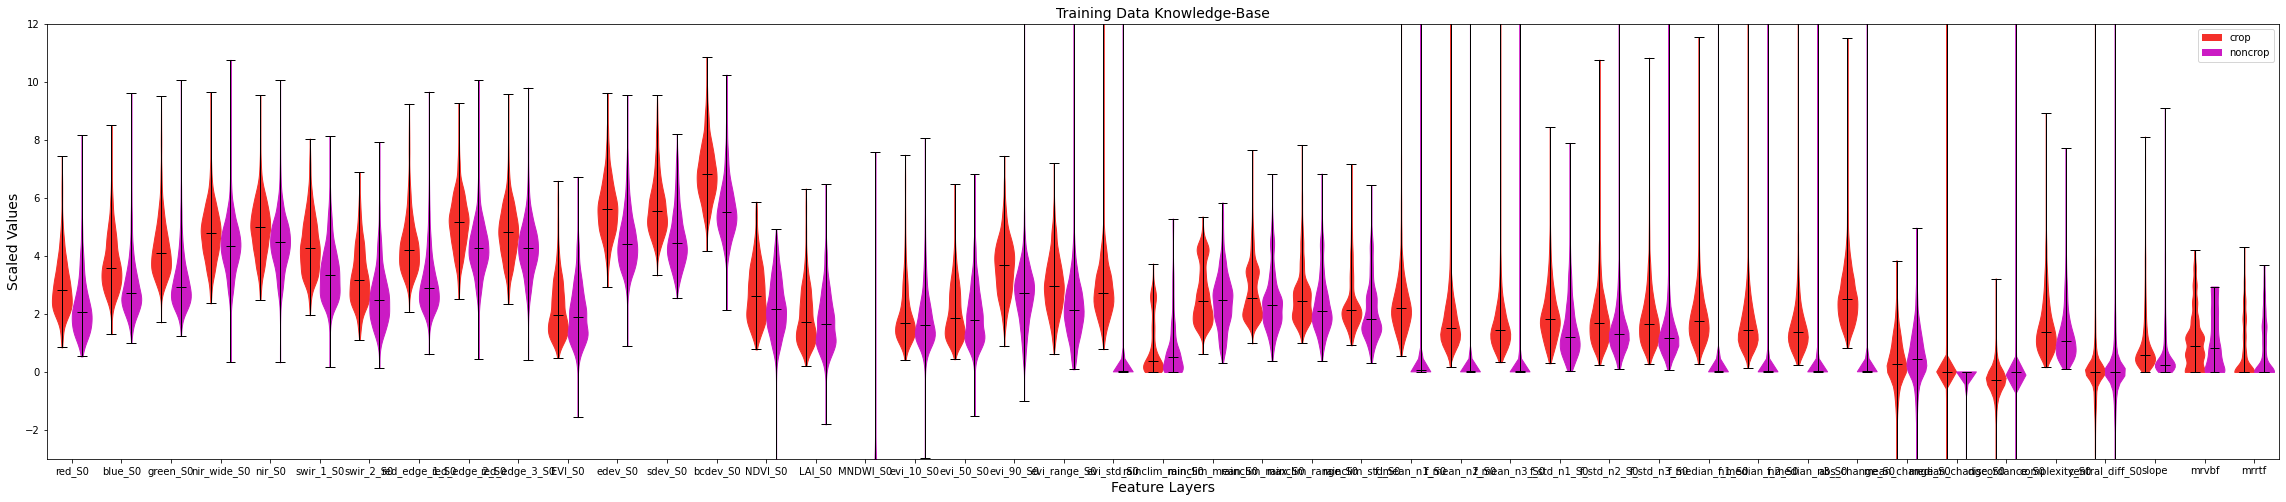

In [7]:
#generate a random list of colors same length as num of classes 
get_colors = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))
colors = get_colors(len(dfs))

#generate list of offsets & widths for plotting
start=-0.2 
end=0.2
offsets = list(np.linspace(start,end,len(dfs)))
if len(dfs) == 2:
    width=0.4
else:
    width=np.abs(offsets[0] - offsets[1])

#create figure and axes 
fig, ax = plt.subplots(figsize=(40,8))

for key, color, offset in zip(dfs,colors, offsets):
    #create violin plots
    pp = ax.violinplot(dfs[key].values,
                       showmedians=True,
                       positions=np.arange(dfs[key].values.shape[1])+offset, widths=width
                      )
    # change the colour of the plots
    for pc in pp['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor(color)
        pc.set_alpha(1)
    
    #change the line style in the plots
    for partname in ('cbars','cmins','cmaxes','cmedians'):
        vp = pp[partname]
        vp.set_edgecolor('black')
        vp.set_linewidth(1)

#tidy the plot, add a title and legend
ax.set_xticks(np.arange(len(column_names[1:])))
ax.set_xticklabels(column_names[1:])
ax.set_ylim(-3.0,12)
ax.set_xlim(-0.5,len(column_names[1:])-.5)
ax.set_ylabel("Scaled Values", fontsize=14)
ax.set_xlabel("Feature Layers", fontsize=14)
ax.set_title("Training Data Knowledge-Base", fontsize=14)
ax.legend([Patch(facecolor=c) for c in colors], [key for key in dfs], loc='upper right');

# Feature Importance

Here we extract classifier estimates of the relative importance of each feature for training the classifier. This is useful for potentially selecting a subset of input bands/variables for model training/classification (i.e. optimising feature space). However, in this case, we are not selecting a subset of features, but rather just trying to understand the importance of each feature.

Results will be presented in asscending order with the most important features listed last. Importance is reported as a relative fraction between 0 and 1.

In [8]:
model=RandomForestClassifier()
model.fit(model_input[:, model_col_indices], model_input[:, 0])

RandomForestClassifier()

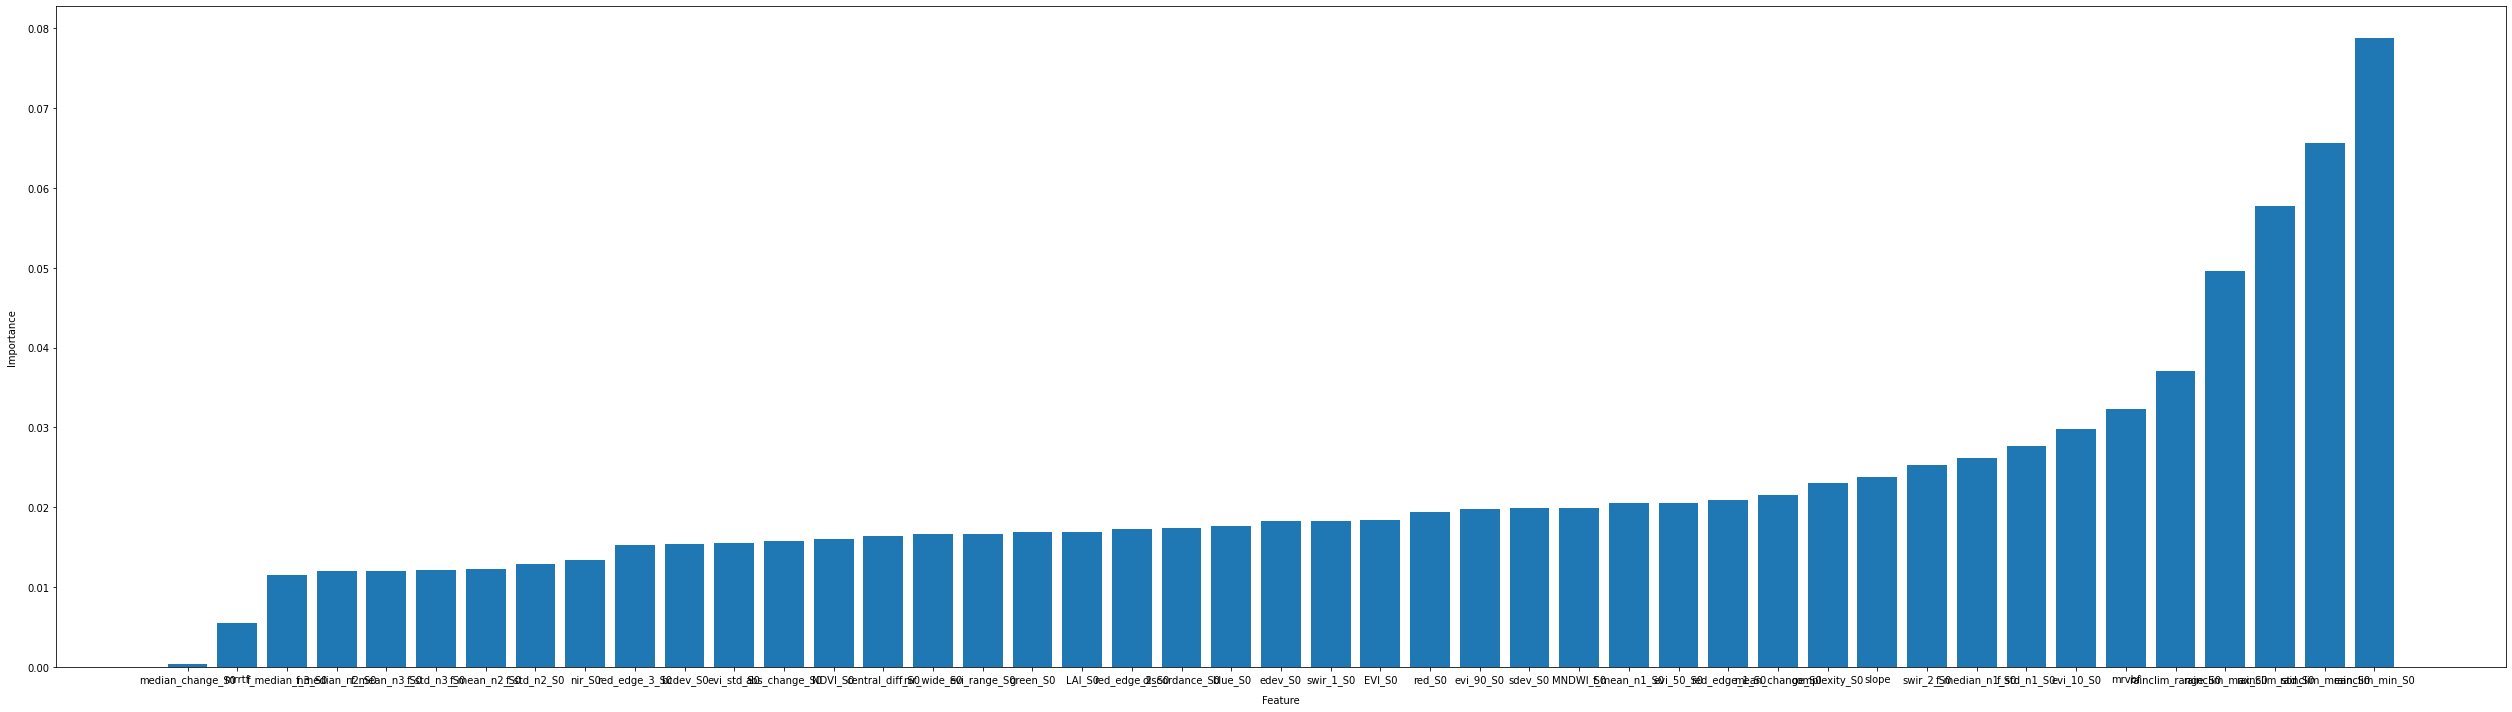

In [9]:
order = np.argsort(model.feature_importances_)

plt.figure(figsize=(35,10))
plt.bar(x=np.array(column_names[1:])[order],
        height=model.feature_importances_[order])
# plt.bar(x=column_names[1:], height=model.feature_importances_)
plt.gca().set_ylabel('Importance', labelpad=10)
plt.gca().set_xlabel('Feature', labelpad=10)
plt.tight_layout()

From least important to most important:

In [15]:
print(np.array(column_names[1:])[order][-10:])

['swir_2_S0' 'f_median_n1_S0' 'f_std_n1_S0' 'evi_10_S0' 'mrvbf'
 'rainclim_range_S0' 'rainclim_max_S0' 'rainclim_std_S0'
 'rainclim_mean_S0' 'rainclim_min_S0']


## Principal Component Analysis

The code below will calculate and plot the first two and three principal components of our training dataset. 

The first step is to standardise our data to express each feature layer in terms of mean and standard deviation, this is necessary because principal component analysis is quite sensitive to the variances of the initial variables. If there are large differences between the ranges of initial variables, those variables with larger ranges will dominate over those with small ranges (For example, a variable that ranges between 0 and 100 will dominate over a variable that ranges between 0 and 1), which will lead to biased results. So, transforming the data to comparable scales can prevent this problem.  We do this using sklearn's `StandardScalar` function which will normalise the values in an array to the array's mean and standard deviation via the formuala: `z = (x-u/s)`, where `u` is the mean of and `s` is the standard deviation.

In [11]:
# Compute the mean and variance for each feature
x = StandardScaler().fit_transform(model_input[:,1:])

### Conduct the PCAs

In [12]:
#two components
pca2 = PCA(n_components=2)
pca2_fit = pca2.fit_transform(x)
#three PCA components
pca3 = PCA(n_components=3)
pca3_fit = pca3.fit_transform(x)

#add back to df
pca2_df = pd.DataFrame(data = pca2_fit,
                      columns = ['PC1', 'PC2'])
pca3_df = pd.DataFrame(data = pca3_fit,
                      columns = ['PC1', 'PC2', 'PC3'])

# concat with classes
result2 = pd.concat([pca2_df, pd.DataFrame({'class':model_input[:,0]})], axis=1)
result3 = pd.concat([pca3_df, pd.DataFrame({'class':model_input[:,0]})], axis=1)

In [13]:
a2,b2 = pca2.explained_variance_ratio_
a3,b3,c3 = pca3.explained_variance_ratio_
print("Variance explained by two principal components = " + str(round((a2+b2)*100, 2))+" %")
print("Variance explained by three principal components = " + str(round((a3+b3+c3)*100, 2))+" %")

Variance explained by two principal components = 41.54 %
Variance explained by three principal components = 56.54 %


#### Plot both 2 & 3 principal components


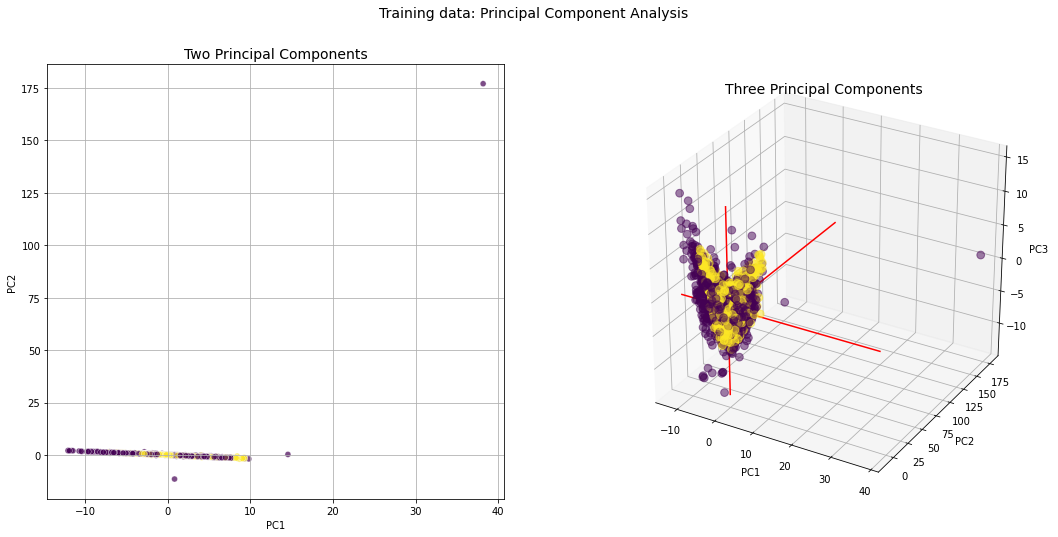

In [14]:
if len(result2) > 5000:
    result2=result2.sample(n=5000)
if len(result3) > 5000:
    result3=result3.sample(n=5000)

fig = plt.figure(figsize=(18,8))
fig.suptitle('Training data: Principal Component Analysis', fontsize=14)

# First subplot
ax = fig.add_subplot(1, 2, 1)
scatter1=sns.scatterplot(x="PC1", y="PC2",
           data=result2,
           hue='class',
           hue_norm=tuple(np.unique(result2['class'])),
           palette='viridis',
           legend=False,
           alpha=0.7,                    
           ax=ax
          )

ax.set_title('Two Principal Components', fontsize=14)
ax.grid(True)

# Second subplot
ax = fig.add_subplot(1, 2, 2, projection='3d')
scatter2 = ax.scatter(result3['PC1'], result3['PC2'], result3['PC3'],
                      c=result3['class'], s=60, alpha=0.5)

# make simple, bare axis lines through space:
xAxisLine = ((min(result3['PC1']), max(result3['PC1'])), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(result3['PC2']), max(result3['PC2'])), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (min(result3['PC3']), max(result3['PC3'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')

ax.set_title('Three Principal Components', fontsize=14)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3");

## Next steps

To continue working through the notebooks in this `Eastern Africa Cropland Mask` workflow, go to the next notebook `3_Train_fit_evaluate_classifier.ipynb`.

1. [Extracting_training_data](1_Extracting_training_data.ipynb) 
2. **Inspect_training_data (this notebook)**
3. [Train_fit_evaluate_classifier](3_Train_fit_evaluate_classifier.ipynb)


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** Dec 2020
